# Artificial Neural Network with Numpy Implementation
 
### Problem Statement
You will classify the [mnist](https://en.wikipedia.org/wiki/MNIST_database) dataset.

These are the filenames contained in [Yann LeCun's mnist dataset](https://yann.lecun.com/exdb/mnist/), where to download them from, and how to save them to your hard drive:

**Train until you reach an accuracy of 90% on the mnist training data and 80% on the mnist test data**

In [1]:
import numpy as np
from urllib import request
import gzip
import pickle
import random
import os
wd = os.getcwd()

## Functions

Functions to download the dataset and load the dataset onto python. Additionally other functions are added for use in the code

In [2]:

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")


def norm(X, x_min, x_max):
    nom = (X - X.min(axis=0)) * (x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom 
  
def prep_data(X, y):

    X_ = []
    y_ = []
    batch_size = 50
    itr = int(len(y) / batch_size) + 1
    print(itr)
    for j in range(1, itr):
        rng = j * batch_size
     

        X_.append(X[rng - batch_size : rng, :])
        y_.append(y[rng - batch_size : rng])


    X, y = np.array(X_), np.array(y_)
    print(y.shape)
    X = norm(X, 0, 1)#[:,:,0]
#    X = X[:,1].squeeze()
#    y = y[:,1].squeeze()
#    y = np.reshape(y,(y.shape[0],1))
    return X, y

def load():
    with open(wd+"\mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
#This is how you could one-hot-encode your labels, so that instead of an integer between 0 and 9 (the mnist digits), you have a 10-D array of ones and zeros:

def one_hot_encode(y, num_labels=10):
    one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)

    for i, val in enumerate(y):
        one_hot[val,i] = 1.0

    return one_hot



def compute_loss(prediction, label):
    term_1 = -1*label * np.log(prediction)
    term_2 = (1 - label) * (np.log(1 - prediction))

    loss = np.sum(term_1 - term_2)
    return loss




## Loading the dataset 

In [3]:
#%%

filename = [
    ["training_images","train-images-idx3-ubyte.gz"],
    ["test_images","t10k-images-idx3-ubyte.gz"],
    ["training_labels","train-labels-idx1-ubyte.gz"],
    ["test_labels","t10k-labels-idx1-ubyte.gz"]
]

download_mnist()
save_mnist()


Download complete.
Save complete.


## Data Manipulation

The loaded dataset is split into the train test data and the shape of the input dataset is analysed

We can see that the data consists of a 3D Array for the image and a 1D array for the label. The data is modified to a 2D array to ensure the neural network can calculate the weights accurately. 


In [4]:
X_train, y_train, X_test, y_test = load()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
a, b = prep_data(X_train, y_train)
print(a.shape,b.shape)
np.any(X_train), np.any(X_test)

print(y_train)
print(y_train.shape)

#a, b = prep_data(X_train, y_train)

#X_train, y_train = prep_data(X_train, y_train)

X_train = X_train.reshape(1200*50,784)

print(len(X_train))

np.count_nonzero(X_train, axis=None) / X_train.size

print(X_train.shape, y_train.shape)


(60000, 784) (60000,) (10000, 784) (10000,)
1201
(1200, 50)
(1200, 50, 784) (1200, 50)
[5 0 4 ... 5 6 8]
(60000,)
60000
(60000, 784) (60000,)


## Data Cleaning

The size of the dataset is modified to ensure the shapes are the same

for the `label` -  `y_train` and `y_test` I transposed the dataset and since the problem is based on a sigmoid equation, I ensure the `label` is between 0 and 1 and hence I used the `one_hot_encode` function given by the professor.

The training and testing dataset `X_train`, `X_test` is normalised between 0 and 1. Since the datasets are images, it can be processed by dividing by 255 or converting to black and white

In [5]:
y_train = one_hot_encode(y_train).transpose()
y_test = one_hot_encode(y_test).transpose()

X_train = norm(X_train,0,1)
X_test = norm(X_test,0,1)

# X_train = X_train / 255
# X_test = X_test / 255

In [6]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


## Visualising the Data

A random set of samples decided by the `num_examples` is viewed using `matplotlib`

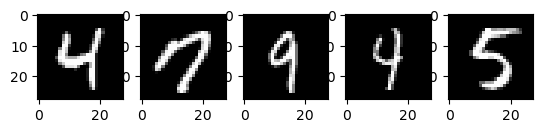

In [7]:
##EXAMPLES
import matplotlib.pyplot as plt
num_examples = 5
seed = 10
rng = np.random.default_rng(seed)
fig, axes = plt.subplots(1, num_examples)
for sample, ax in zip(rng.choice(X_train, size=num_examples, replace=False), axes):
    ax.imshow(sample.reshape(28, 28), cmap="gray")
    

## Building the Aritifical Neural Network / ANN - Step by Step Explaination

1. Taking in the following arguments 
    
* `input_size` and `output_size` are the main but the sizes of the hidden layers can also be given by adding `hidden_layer1_size` and `hidden_layer2_size`
    
    
2. Based on the `input size` ,`output_size` of the dataset and labels the weights of the 3 layers are considered

* `W1`, `W2`, `W3` correspond to the weights of each of the layers assuming a random set of weights


3. Defining a `sigmoid` or logistic activation function


4. A feedforward function with the layers optimised by a logistic activation function and the weights are calculated accordingly 

$$\sigma = \frac{1}{1 + e ^-x}$$ Represents the Sigmoid equation

and 

$$\sigma(x) \cdot (1 - \sigma(x))$$ Represents the derivative of the Sigmoid Equation

$$\hat{y_1} = \sigma(W_1x)$$

$$\hat{y_2} = \sigma\;(W_2\hat{y_1})$$

$$\hat{y_3} = \sigma\;(W_3\hat{y_2})$$



* Combining all 3 equations we get the following. This represents the feedforward mechanism

$$\hat{y} = \sigma(W_3(\sigma\;(W_2\sigma(W_1x))))$$

* The above equation gives the weights at the output layer

* `a1` and `a2` are the hidden layers

* `z1`,`z2` and `z3` are the outputs of the layers during this stage - obtained by dot prouducts 


    
5. The most important step is Backpropogation according to this step the loss is calculated by taking the derivative according to the loss function specified . 

    Error between predicted and actual labels is given by  $\hat{y} - y$ and the RMSE loss function is as follows.

    $$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}$$

    We want to calculate the gradient of the RMSE loss function with respect to the predicted output y_hat. This is given by:


    $$\frac{\partial\;(RMSE)}{\partial \hat y} = \frac{1}{n} * (y - \hat y)$$ 

        The RMSE is used to find the loss with respect to the output during the epoch so that it can be relayed back to the      weights

    `(self.y - self.y_pred)`

    *The Derivative of the sigmoid function is given by the `sigmoid_derivative` function*. 

    For the overall architecture of the Neural Network we have to calculate the loss and propogate the results back to the input layer for the weights to be optimised. 

    $$\frac{\partial \;Loss_3(y, \hat{y})}{\partial W^3} = 
    \frac{\partial \;Loss_3(y, \hat{y})}{\partial \hat{y}} * \frac{\partial\hat{y}}{\partial W^3} =
    \sum_i \; (y - \hat{y}) * \frac{\partial\hat{y}}{\partial W^3}$$

    $$\frac{\partial \;Loss_2(y, \hat{y})}{\partial W^2} = 
    \frac{\partial \;Loss_2(y, \hat{y})}{\partial \hat{y}}* \frac{\partial\hat{y}}{\partial a_2} * \frac{\partial a_2}{\partial W^2} =
    \sum_i \; (y - \hat{y}) * \frac{\partial\hat{y}}{\partial a_2} * 
    \frac{\partial a_2}{\partial W^2}$$

    $$\frac{\partial \;Loss_1(y, \hat{y})}{\partial W^1} = 
    \frac{\partial \;Loss_1(y, \hat{y})}{\partial \hat{y}}* \frac{\partial\hat{y}}{\partial a_1} * \frac{\partial a_1}{\partial W^1} =
    \sum_i \; (y - \hat{y}) * \frac{\partial\hat{y}}{\partial a_1} * 
    \frac{\partial a_1}{\partial W^1}$$

    $$a_1 = \sigma(W_1)$$

    $$a_2 = \sigma(W_2 * a_1)$$

    $$\hat y = \sigma(W_3 * a_2)$$


    Plugging in the equations we get the following

    $$\frac{\partial \;Loss_3(y, \hat{y})}{\partial W^3}  =
    \sum_i \; (y - \hat{y}) * \frac{\partial\sigma(W_3 * a_2)}{\partial W^3}$$

    $$\frac{\partial \;Loss_2(y, \hat{y})}{\partial W^2} =
    \sum_i \; (y - \hat{y}) * \frac{\partial\sigma(W_3 * a_2)}{\partial a_2} * 
    \frac{\partial \sigma(W_2 * a_1)}{\partial W^2}$$
    '
    $$\frac{\partial \;Loss_1(y, \hat{y})}{\partial W^1} =
    \sum_i \; (y - \hat{y}) * \frac{\partial\hat{y}}{\partial a_1} * 
    \frac{\partial a_2}{\partial W^2}$$

    Final set of equations 

    $$\frac{\partial \;Loss_3(y, \hat{y})}{\partial W^3}  = (y - \hat{y}) * \sigma' (z^{(3)})$$

    $$\frac{\partial \;Loss_2(y, \hat{y})}{\partial W^2} = (y - \hat{y}) *  \sigma' (z^{(3)}) * W^{(2)}  *  \sigma' (z^{(2)})$$

    $$\frac{\partial \;Loss_1(y, \hat{y})}{\partial W^1} = (y - \hat{y}) *  \sigma' (z^{(3)}) * W^{(2)}  *  \sigma' (z^{(2)})  * W^{(1)}) * \sigma' (z^{(1)})$$

6. Training the dataset - A minibatch of size 50 is used in this Neural Network with a learning rate of 0.1. The accuracy is calculated by the `accuracy` function and the loss is calculated by the `rmse_loss` function


7. For testing some data, the test data can be reloaded using the `reload` function and fed forward after which the metrics of the prediction can be analysed 

## Implementing the above architecture in Python

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the RMSE loss function
def rmse_loss(y_t, y_p):
    return np.sqrt(np.mean((y_t - y_p)**2))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

class ArtificialNeuralNetwork:
    
    def __init__(self, input_size,output_size, hidden_layer1_size = 100, hidden_layer2_size = 100):
        
        
        self.input_size         = input_size
        self.hidden_layer1_size = hidden_layer1_size
        self.hidden_layer2_size = hidden_layer2_size
        self.output_size        = output_size
        self.W1                 = np.random.randn(input_size, hidden_layer1_size)
        self.W2                 = np.random.randn(hidden_layer1_size, hidden_layer2_size)
        self.W3                 = np.random.randn(hidden_layer2_size, output_size)

    
    def feedforward(self):        
        self.z1 = self.X.dot(self.W1)
        self.a1 = sigmoid(self.z1)
        self.z2 = self.a1.dot(self.W2)
        self.a2 = sigmoid(self.z2)
        self.z3 = self.a2.dot(self.W3)
        self.y_pred = sigmoid(self.z3)


        self.loss = rmse_loss(self.y, self.y_pred)
        
    def backpropogation(self):
        
        loss3 = (self.y - self.y_pred) * sigmoid_derivative(self.z3)
        #loss3 = rmse_derivative(self.y,self.y_pred) * sigmoid_derivative(self.z3)
        loss2 = loss3.dot(self.W3.T) * sigmoid_derivative(self.z2)
        loss1 = loss2.dot(self.W2.T) * sigmoid_derivative(self.z1)
        self.W3 += self.a2.T.dot(loss3) * 0.1
        self.W2 += self.a1.T.dot(loss2) * 0.1
        self.W1 += self.X.T.dot(loss1)  * 0.1
        
    def training(self, X_train, y_train, num_epochs, batch_size):
        num_batches = X_train.shape[0] // batch_size        
        
        for epoch in range(num_epochs):
            
            for batch in range(num_batches):
                lower = batch*batch_size
                upper = (batch+1)*batch_size
                
                X_batch = X_train[lower:upper]
                y_batch = y_train[lower:upper]

                self.X = X_batch
                self.y = y_batch
                
                self.feedforward()
                
                self.backpropogation()
                
            self.X = X_train
            self.y = y_train
            self.feedforward()
            accuracy = self.accuracy(self.X, self.y)         
            print("The accuracy of the training data after "+str(epoch)+" Epochs is "+ str(accuracy*100) + " %")
            if (epoch+1) % 2 == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - loss: {self.loss:.4f}")          
            if accuracy > 0.9:
                print("The Neural Network has converged at the desired accuracy")
                break                
            
    def reload(self, x,y):
        self.X = x
        self.y = y

    def predict(self):
        return self.z3#self.output
    
    def accuracy(self, X, y):
        self.reload(X,y)
        self.feedforward()
        predicted_class = np.argmax(self.z3, axis=1)
        accuracy = np.mean(predicted_class == np.argmax(y, axis=1))        
        return accuracy



## Initialise an ANN

In [9]:
#random.seed(10)
nn = ArtificialNeuralNetwork(input_size = X_train.shape[1],output_size = y_train.shape[1])

## Training the ANN

`num_epochs` handles the Number of Epochs and `batch_size` ensure the rate described in the question which is **50**.

<font color='red'>Note : The training process is iterative and if the ANN fails to converge at the 90 % mark please increase the number of epochs</font>

In [10]:
nn.training(X_train = X_train, y_train = y_train,  num_epochs = 50, batch_size = 50)

The accuracy of the training data after 0 Epochs is 70.89833333333333 %
The accuracy of the training data after 1 Epochs is 75.285 %
Epoch 2/25 - loss: 0.1718
The accuracy of the training data after 2 Epochs is 76.32166666666666 %
The accuracy of the training data after 3 Epochs is 76.75999999999999 %
Epoch 4/25 - loss: 0.1634
The accuracy of the training data after 4 Epochs is 77.10666666666667 %
The accuracy of the training data after 5 Epochs is 77.42833333333333 %
Epoch 6/25 - loss: 0.1594
The accuracy of the training data after 6 Epochs is 77.76833333333333 %
The accuracy of the training data after 7 Epochs is 78.00833333333334 %
Epoch 8/25 - loss: 0.1561
The accuracy of the training data after 8 Epochs is 78.19 %
The accuracy of the training data after 9 Epochs is 78.32833333333333 %
Epoch 10/25 - loss: 0.1540
The accuracy of the training data after 10 Epochs is 78.505 %
The accuracy of the training data after 11 Epochs is 78.99833333333333 %
Epoch 12/25 - loss: 0.1527
The accura

## Testing on a test Dataset

### Visually Seeing the output

For comparing the labels and predicted values I have taken a random set of Pictures to look at to visually confirm whether the model was able to predict with accuracy


In [11]:
# rng.choice(X_train[10:20])
import random
check = [random.randint(1,X_test.shape[0]) for x in range(1,51)]
print(check)

[4706, 2249, 7223, 8495, 676, 4327, 6056, 231, 1387, 3871, 791, 3450, 3586, 5931, 1998, 9204, 1146, 7777, 3354, 1838, 7671, 7641, 9883, 2659, 6502, 9718, 3261, 7994, 3462, 6159, 4027, 1901, 9759, 1378, 6760, 81, 2462, 3817, 5701, 7820, 2473, 6583, 8681, 1840, 5763, 6908, 6098, 4462, 149, 7091]


In [12]:
nn.reload(X_test[check],y_test[check])
nn.feedforward()
oo = nn.predict()

* The first list shows the predicted labels

* The graphic shows the actual labels

[9 4 1 2 7 0 8 3 6 8]


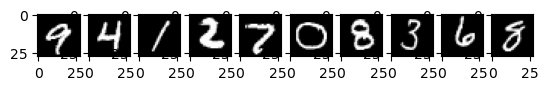

In [13]:
##EXAMPLES
import matplotlib.pyplot as plt
num_examples = 10
fig, axes = plt.subplots(1, num_examples)
for sample, ax in zip(X_test[check], axes):
    ax.imshow(sample.reshape(28, 28), cmap="gray")
    
predicted_class = np.argmax(oo, axis=1)
print(predicted_class[:num_examples])

## Overall Accuracy of Test Data

From the above visuals we can see that our model did predict **almost all  the labels accurately**

In [14]:
accuracy = nn.accuracy(X_test, y_test)
print("Accuracy of the test Dataset ", accuracy * 100)

Accuracy of the test Dataset  95.16


# Conclusion - Key Takeaways

* We have designed a Neural Network which can classify the above images with an **accuracy of atleast 90 %** on the training data and **accuracy of 80 %** on the test data.

* Along with a Python implementation of the ANN I have also derived the equations for the different layers. 

* The above architecture was implemented with just a sigmoid function and a root mean squared error based loss function. 

* However it can be optimised by leveraging activation functions like `softmax`which is used for multi-class classification problems like this one. 

* Optimisers and biases can also aid the training of the neural network to work faster and handle more datasets.
